# Advanced Data Modelling

Since now I have learned Ensemble techniques as well as Neural Networks, lets try them out here:

In [2]:
import pandas as pd
import numpy as np

# get the data from the file
file_path = './data/preprocessed_all_tweets.csv'  # Update path as needed
embedded_data = pd.read_csv(file_path)
X = embedded_data['processed_text']
y = embedded_data['hashtag']

# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Ensemble best of models and combine them together

Logistic Regression	{'C': 10, 'solver': 'saga', 'max_features': None, 'method': 'tfidf', 'stop_words': 'english'}
Decision Tree	{'max_depth': None, 'min_samples_split': 5, 'max_features': None, 'method': 'count', 'stop_words': 'english'}
K-Nearest Neighbors	{'n_neighbors': 5, 'weights': 'distance', 'max_features': None, 'method': 'tfidf', 'stop_words': 'english'}
Naive Bayes	{'alpha': 0.1, 'max_features': None, 'method': 'tfidf', 'stop_words': 'english'}

Train accuracy: 1.0
Test Accuracy: 0.625
{'#AEWDynamite': {'precision': 1.0, 'recall': 0.375, 'f1-score': 0.5454545454545454, 'support': 8.0}, '#AskAiah': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2.0}, '#BBMAs': {'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1-score': 0.8888888888888888, 'support': 9.0}, '#CUTOSHI': {'precision': 0.6666666666666666, 'recall': 0.8571428571428571, 'f1-score': 0.75, 'support': 7.0}, '#GSWvsHOU': {'precision': 0.8, 'recall': 0.5714285714285714, 'f1-score': 0.6666666666666666, 'support': 7.0}, '#PMSLive': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1-score': 0.5714285714285714, 'support': 8.0}, '#RHOSLC': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.8235294117647058, 'support': 8.0}, '#Survivor47': {'precision': 0.7, 'recall': 0.875, 'f1-score': 0.7777777777777778, 'support': 8.0}, '#TNFonPrime': {'precision': 0.4, 'recall': 0.25, 'f1-score': 0.3076923076923077, 'support': 8.0}, '#TheGameAwa

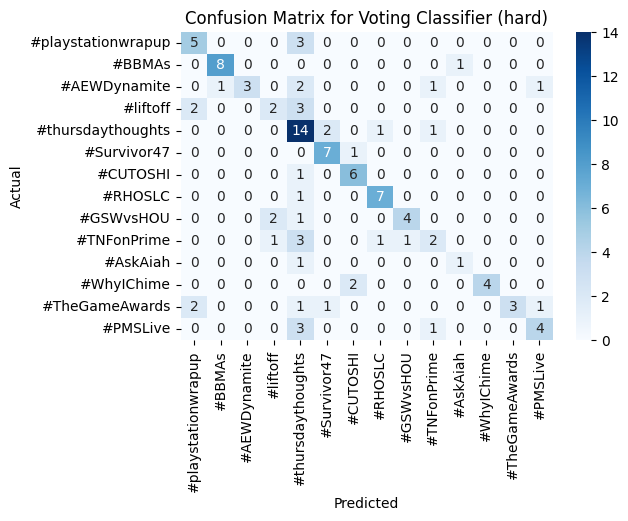

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


hashtags = embedded_data['hashtag'].unique()

# Define pipelines for each model
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=None, stop_words='english')),
    ('logreg', OneVsRestClassifier(LogisticRegression(max_iter=1000, C = 10, solver = 'saga')))
])

dt_pipeline = Pipeline([
    ('count', CountVectorizer(max_features=None, stop_words='english')),
    ('dt', DecisionTreeClassifier(max_depth = None, min_samples_split = 5, max_features = None))
])

knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=None, stop_words='english')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
])

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=None, stop_words='english')),
    ('nb', MultinomialNB(alpha=0.1))
])

# Combine models using VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),
        ('dt', dt_pipeline),
        ('knn', knn_pipeline),
        ('nb', nb_pipeline)
    ],
    voting='hard'
)

# Fit and evaluate the model
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Print accuracy
print("Train accuracy:", voting_clf.score(X_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, output_dict=True))
cm = confusion_matrix(y_test, y_pred, labels=hashtags)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=hashtags, yticklabels=hashtags)
plt.title(f"Confusion Matrix for Voting Classifier (hard)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




### Lets play with Grid Search and see what we can get by playing around with different weights and voting

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for weights
param_grid = {
    'weights': [
        (1, 1, 1, 1),  # Equal weights
        (2, 1, 1, 1),  # Logistic Regression gets more weight
        (1, 2, 1, 1),  # Decision Tree gets more weight
        (1, 1, 2, 1),  # KNN gets more weight
        (1, 1, 1, 2),  # Naive Bayes gets more weight
        (2, 1, 2, 4),  # Logistic Regression highly favored
    ], 'voting': [
        'hard', 'soft'
    ]
}

# Define the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),
        ('dt', dt_pipeline),
        ('knn', knn_pipeline),
        ('nb', nb_pipeline)
    ]
)



# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Or another suitable metric
    verbose=1,
    n_jobs=-1  # Use all processors for speed
)

# Fit the grid search to find the best weights
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the test set
best_voting_clf = grid_search.best_estimator_
y_pred = best_voting_clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'voting': 'hard', 'weights': (1, 2, 1, 1)}
Best Score: 0.5878378378378378
Test Accuracy: 0.6071428571428571


In [8]:
# Print the scores for each combination
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_voting,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.188374,0.012196,0.009030,0.002276,hard,"(1, 1, 1, 1)","{'voting': 'hard', 'weights': (1, 1, 1, 1)}",0.533784,0.574324,0.648649,0.585586,0.047565,2
1,0.192879,0.013848,0.017539,0.003756,hard,"(2, 1, 1, 1)","{'voting': 'hard', 'weights': (2, 1, 1, 1)}",0.533784,0.533784,0.662162,0.576577,0.060518,3
2,0.192199,0.014473,0.007707,0.001217,hard,"(1, 2, 1, 1)","{'voting': 'hard', 'weights': (1, 2, 1, 1)}",0.540541,0.560811,0.662162,0.587838,0.053203,1
3,0.182073,0.013541,0.007049,0.000108,hard,"(1, 1, 2, 1)","{'voting': 'hard', 'weights': (1, 1, 2, 1)}",0.520270,0.554054,0.648649,0.574324,0.054335,4
4,0.190408,0.017546,0.008773,0.002730,hard,"(1, 1, 1, 2)","{'voting': 'hard', 'weights': (1, 1, 1, 2)}",0.520270,0.547297,0.655405,0.574324,0.058385,5
5,0.199123,0.028179,0.010310,0.001493,hard,"(2, 1, 2, 4)","{'voting': 'hard', 'weights': (2, 1, 2, 4)}",0.513514,0.547297,0.662162,0.574324,0.063624,5
6,0.189248,0.021698,0.007642,0.001524,soft,"(1, 1, 1, 1)","{'voting': 'soft', 'weights': (1, 1, 1, 1)}",0.540541,0.513514,0.621622,0.558559,0.045937,9
7,0.195445,0.018614,0.006691,0.000785,soft,"(2, 1, 1, 1)","{'voting': 'soft', 'weights': (2, 1, 1, 1)}",0.540541,0.513514,0.614865,0.556306,0.042852,10
8,0.180097,0.023951,0.012606,0.008932,soft,"(1, 2, 1, 1)","{'voting': 'soft', 'weights': (1, 2, 1, 1)}",0.506757,0.479730,0.574324,0.520270,0.039783,12
9,0.194165,0.006810,0.006536,0.000181,soft,"(1, 1, 2, 1)","{'voting': 'soft', 'weights': (1, 1, 2, 1)}",0.547297,0.527027,0.628378,0.567568,0.043789,8


## Try Soft Voting

Train accuracy: 1.0
Test Accuracy: 0.5714285714285714
{'#AEWDynamite': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 8.0}, '#AskAiah': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 2.0}, '#BBMAs': {'precision': 0.875, 'recall': 0.7777777777777778, 'f1-score': 0.8235294117647058, 'support': 9.0}, '#CUTOSHI': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 7.0}, '#GSWvsHOU': {'precision': 0.8, 'recall': 0.5714285714285714, 'f1-score': 0.6666666666666666, 'support': 7.0}, '#PMSLive': {'precision': 0.3333333333333333, 'recall': 0.375, 'f1-score': 0.35294117647058826, 'support': 8.0}, '#RHOSLC': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.8235294117647058, 'support': 8.0}, '#Survivor47': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 8.0}, '#TNFonPrime': {'precision': 0.5714285714285714, 'recall': 0.5, 'f1-score': 0.5333333333333333,

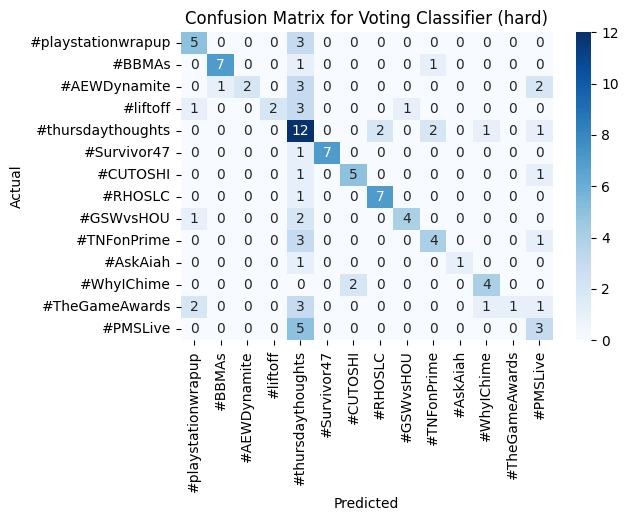

In [6]:
# Combine models using VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_pipeline),
        ('dt', dt_pipeline),
        ('knn', knn_pipeline),
        ('nb', nb_pipeline)
    ],
    voting='soft'
)

# Fit and evaluate the model
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Print accuracy
print("Train accuracy:", voting_clf.score(X_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, output_dict=True))
cm = confusion_matrix(y_test, y_pred, labels=hashtags)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=hashtags, yticklabels=hashtags)
plt.title(f"Confusion Matrix for Voting Classifier (soft)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Lets play with RandomForest Too

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Text vectorization using Tfidf
# Train RandomForestClassifier
rf_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=None, stop_words='english')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Random Forest Classifier")
print("Accuracy:", accuracy)



Random Forest Classifier
Accuracy: 0.5535714285714286


'                    precision    recall  f1-score   support\n\n      #AEWDynamite       0.50      0.12      0.20         8\n          #AskAiah       1.00      0.50      0.67         2\n            #BBMAs       1.00      0.78      0.88         9\n          #CUTOSHI       0.83      0.71      0.77         7\n         #GSWvsHOU       1.00      0.29      0.44         7\n          #PMSLive       0.40      0.25      0.31         8\n           #RHOSLC       1.00      0.88      0.93         8\n       #Survivor47       1.00      0.88      0.93         8\n       #TNFonPrime       0.67      0.50      0.57         8\n    #TheGameAwards       0.50      0.12      0.20         8\n        #WhyIChime       1.00      0.67      0.80         6\n          #liftoff       0.50      0.29      0.36         7\n#playstationwrapup       0.50      0.75      0.60         8\n #thursdaythoughts       0.28      0.72      0.40        18\n\n          accuracy                           0.55       112\n         macro avg 

#### GridSearch on RandomForest

In [15]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'rf__n_estimators': [50, 100, 200],  # Number of trees
    'rf__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'rf__min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'rf__class_weight': [None, 'balanced'],  # Handle imbalanced classes
}

# Create the GridSearchCV object
rf_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=None, stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))
])
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all processors for speed
)

# Fit the grid search
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


Fitting 3 folds for each of 216 candidates, totalling 648 fits
0.5982142857142857


In [16]:
print(best_params, best_score)
print(accuracy_score(y_test, y_pred))


{'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 50} 0.5833333333333334
0.5982142857142857
